# Conv2D layer

## import libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from pprint import pprint

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## Defining Layer

In [0]:
# Put your answer here

from tensorflow.keras import layers


class Donv2D(layers.Layer):

  def conv2d(self,kernel_size,kernel_count,images):
    if(len(images.shape) == 3):
      images = tf.reshape(images,(images.shape[0],images.shape[1],images.shape[2],1)) ## in case of input image
    else:
      images = tf.reshape(images,(images.shape[0],images.shape[1],images.shape[2],images.shape[3])) ## in case of in between layers
   
    image_base = images.shape[0],images.shape[1]
   
    patches = tf.image.extract_patches(
      images=images,
      sizes=[1, kernel_size[0],kernel_size[1], 1],
      strides=[1,1,1, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'
    )
    
    output_filters = (patches.shape[1],patches.shape[2])
    patches = tf.reshape(patches,(patches.shape[0],patches.shape[1]*patches.shape[2],patches.shape[3]))
    patches = tf.dtypes.cast(
        patches,
        tf.dtypes.float32,
    )
    patches= tf.transpose(patches,(0,2,1))
    
    conv = tf.matmul(self.filters,patches)
    conv = tf.reshape(conv,(image_base[0],output_filters[0],output_filters[1],kernel_count))

    return conv

  def __init__(self, kernel_count,kernel_size,input_depth=32):
    super(Donv2D, self).__init__()
    self.kernel_count = kernel_count
    self.kernel_size = kernel_size
    self.valid = False
    w_init = tf.random_normal_initializer()
    self.filters = self.add_weight(shape=(kernel_count,kernel_size[0]*kernel_size[1]*input_depth),
                             initializer='random_normal',
                             trainable=True)
    
  def call(self, inputs):   
      return self.conv2d(self.kernel_size,self.kernel_count,inputs)
  

## Defining Model

In [0]:
from tensorflow.keras.datasets import mnist

class Conv(tf.keras.Model):

    def __init__(self,num_classes):
        super(Conv, self).__init__()
        self.block_1 = Donv2D(20,(3,3),1)
        self.block_2 = Donv2D(32,(3,3),20)
        self.block_3 = Donv2D(64,(3,3),32)
        self.flatten = tf.keras.layers.Flatten()
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes)
        self.dense = tf.keras.layers.Dense(100)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        self.relu = tf.keras.layers.Activation('relu')

    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.relu(x)
        # print(x.shape)
        # print("One is Done")
        x = self.block_2(x)
        x = self.relu(x)
        # print(x.shape)
        # print("Two is Done")
        x = self.block_3(x)
        x = self.relu(x)
        # print(x.shape)
        # print("Three is Done")
        x = self.global_pool(x)
        # print("Connected")
        x = self.flatten(x)
        x = self.relu(x)
        # print(x.shape)
        x = self.dense(x)
        x = self.relu(x)

        # print(x.shape)
        x = self.classifier(x)
        x = self.sigmoid(x)

        # print(x.shape)


        return x


## Problem 1
Mnist Digit Recognition

### import data

In [0]:
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
x_train.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

### visualization

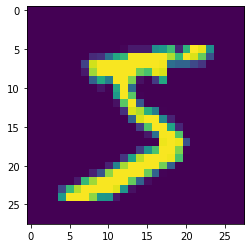

In [0]:
plt.imshow(x_train[0])
plt.title = y_train[0]

### Training Model

In [0]:
conv = Conv(10)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()
acc =  tf.keras.metrics.CategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
seen = True
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
epochs = 10

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    # print(y_batch_train.shape)
    with tf.GradientTape() as tape:
      y_pred = conv(x_batch_train)   
      loss_value = loss_fn(y_batch_train, y_pred)
      a = acc(y_batch_train, y_pred)
    grads = tape.gradient(loss_value, conv.trainable_weights)
    optimizer.apply_gradients(zip(grads, conv.trainable_weights))

    if step % 100 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Training acc (for one batch) at step %s: %s' % (step, float(a)))
        print('Seen so far: %s samples' % ((step + 1) * 64))


Start of epoch 0
Training loss (for one batch) at step 0: 2.4747869968414307
Training acc (for one batch) at step 0: 0.0625
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.9148193001747131
Training acc (for one batch) at step 100: 0.6155630946159363
Seen so far: 6464 samples
Training loss (for one batch) at step 200: 0.3151840567588806
Training acc (for one batch) at step 200: 0.7356964945793152
Seen so far: 12864 samples
Training loss (for one batch) at step 300: 0.3452046513557434
Training acc (for one batch) at step 300: 0.7872197031974792
Seen so far: 19264 samples
Training loss (for one batch) at step 400: 0.17904913425445557
Training acc (for one batch) at step 400: 0.8208385109901428
Seen so far: 25664 samples
Training loss (for one batch) at step 500: 0.19866925477981567
Training acc (for one batch) at step 500: 0.8424713015556335
Seen so far: 32064 samples
Training loss (for one batch) at step 600: 0.19249111413955688
Training acc (for one batch) at step 6

### Evaluation

In [0]:
y_pred = conv(x_test)  # Logits for this 
a = acc(y_test, y_pred)
print(a)

tf.Tensor(0.9718164, shape=(), dtype=float32)


Accuracy is %97.18 